Notebook for various spectra visualization methods
Will work against persisted data here, but methods should work in other contexts

In [1]:
#imports and env
import numpy as np
import sys
import os
from matplotlib import pyplot as plt
from pathlib import Path
import plotly.graph_objects as go

#update path to use our packages
sys.path.insert(0, os.path.abspath('..'))
from libs_unet.training.spec_maker import spectrum_maker
#define absolute path to repo top level and then relative vs. that
top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
datapath = top_dir / 'data'

In [2]:
#should recover the same Li2CO3 spectrum here as we get from the NIST LIBS website
fracs_dict = {'Li':0.33, 'C':0.17, 'O':0.5}
my_maker = spectrum_maker()
wave, spec_dict, lines_dict = my_maker.make_spectra(fracs_dict)

In [3]:
#import the expermental libs spectra from LBNL
libs_spec = np.genfromtxt(datapath / "experimental/LIBS_Li2CO3.csv", delimiter=',', skip_header=1)
#transform to 1nm resolution for consistent scaling
#resample to our model specs for wavelength resolution
libs_wave = libs_spec[:,0]
libs_intens = libs_spec[:,1]

In [4]:
libs_intens.shape


(23431,)

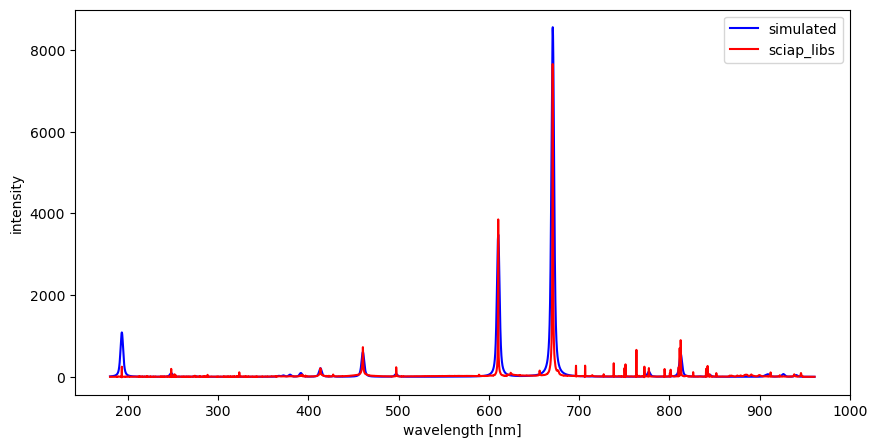

In [5]:
#Look at an apples to apples scaling
nist_spec = spec_dict['comp']

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(wave, nist_spec, color='blue', label='simulated') 
plt.plot(libs_wave,libs_intens, color='red', label='sciap_libs')
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.yscale('log')
plt.legend()
#plt.show

In [6]:
#Read in the nist website libs data for Li2CO3 for comparison too
nist_libs = np.genfromtxt(datapath / "nist_libs/Li2CO3_nist_libs.csv", delimiter=',', skip_header=1, filling_values=0)

<function matplotlib.pyplot.show(close=None, block=None)>

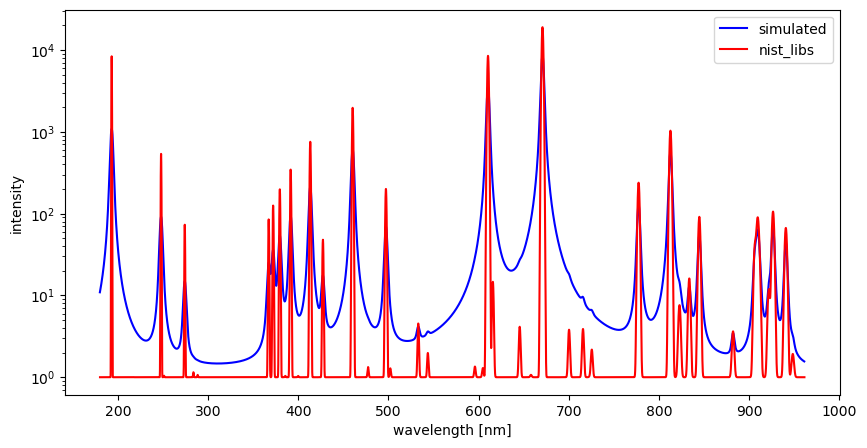

In [7]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(wave, nist_spec+1, color='blue', label='simulated') 
plt.plot(nist_libs[:,0],nist_libs[:,1]+1, color='red', label='nist_libs')
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.yscale('log')
plt.legend()
plt.show
#can see the lines->peaks used by NIST much tighter than our default

In [8]:
#compare the sum of lines coming back to the nist lines for Li2CO3. Should be same
nist_lines = np.genfromtxt(datapath / "nist_libs/Li2CO3_nist_lines.csv", delimiter=',', skip_header=1, filling_values=0)

In [9]:
len(nist_lines)
nist_lines.shape

(1033, 10)

In [10]:
#aggregate all the intensities to a single sum for each wavelength
#for each nist line, need to put on wavelength domain of our simulated lines
line_wl = nist_lines[:,0]
line_int = np.sum(nist_lines[:,1:], axis=1)
full_nist_lines = np.zeros(len(wave))
wl_inc = wave[1] - wave[0]
for i in range(len(line_wl)):
    if line_wl[i] < np.min(wave) or line_wl[i] > np.max(wave):
        continue
    else:
        wl_ind = np.round((line_wl[i]-np.min(wave)) / wl_inc, 0).astype('int')
        full_nist_lines[wl_ind] += line_int[i]

In [11]:
#we should see the same lines from spec-maker (within precision of SciAps res used) as from NIST LIBS
# See where max Li intensity is shifted (note, analytics should take an interval around atomic target)
max_mask = np.all([wave >= 670, wave < 671], axis=0)
col_head = ['wavelength', 'nist_libs', 'spec_maker']
col_wave = wave[max_mask]
col_nist = full_nist_lines[max_mask]
col_maker = lines_dict['comp'][max_mask]


fig = go.Figure(data=[go.Table(header=dict(values=col_head),
                 cells=dict(values=[col_wave, col_nist, col_maker]))
                     ])
fig.show()
#perfect match

In [16]:
#create arbitrary spectra from simulation
fracs_dict = {'Sn':0.9, 'Pr':0.1}
wave, spec_dict, lines_dict = my_maker.make_spectra(fracs_dict, comp_only=True)

<function matplotlib.pyplot.show(close=None, block=None)>

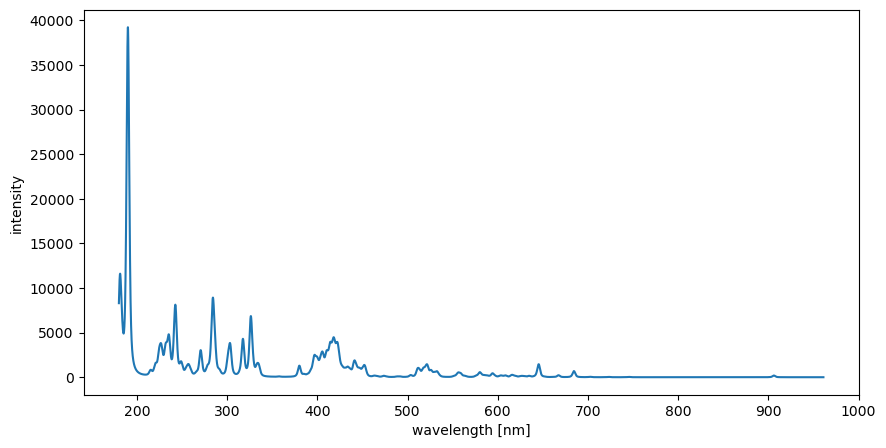

In [13]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(wave, spec_dict['comp']) 
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.yscale('log')
#plt.legend()
plt.show

In [17]:
#Spec maker is slow with ~24k wl points
#check what unique set of wl in nist atomic lines is
#existing dataset used by spec_maker has nist atomic lines on a standard wl grid (180-961 @ 0.0333nm res)
#can basically look for zero intensity points on a composite with all elements
n_elem = len(my_maker.avail_elem)
fracs_dict = {el:1/n_elem for el in my_maker.avail_elem}
wave, all_spec_dict, all_lines_dict = my_maker.make_spectra(fracs_dict, comp_only=True)

In [27]:
#can reduce the set to 270 lines with a threshold of 1000
thresh = 500
np.sum(all_lines_dict['comp'] > thresh)

486

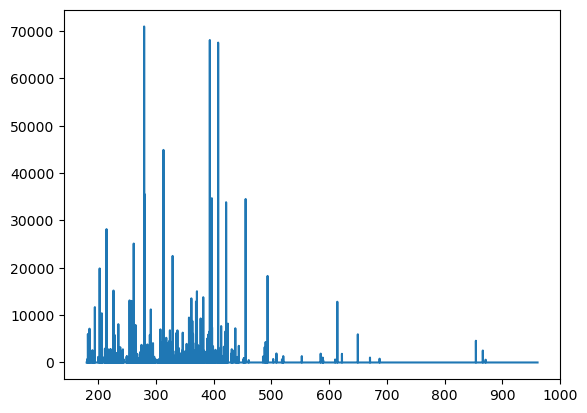

In [28]:
plt.plot(wave,np.where(all_lines_dict['comp'] > thresh, all_lines_dict['comp'], 0))